In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [2]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv", encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [3]:
# Your code
from sklearn.model_selection import train_test_split

# Divide the dataset into two partitions: training and testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

# ... existing code ...

Training Data Shape: (800, 2)
Testing Data Shape: (200, 2)


## Data Preprocessing

In [4]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [7]:
from bs4 import BeautifulSoup
from bs4 import Comment
import re

def clean_html(html_content):
    # Handle NaN or non-string values
    if not isinstance(html_content, str):
        return ""
    
    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")
    
    # 1. Remove inline JavaScript/CSS
    for script_or_style in soup(["script", "style"]):
        script_or_style.decompose()
    
    # 2. Remove HTML comments
    comments = soup.findAll(text=lambda text: isinstance(text, Comment))
    for comment in comments:
        comment.extract()
    
    # 3. Remove remaining HTML tags and get the text
    cleaned_text = soup.get_text()
    
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Apply the cleaning function to the column containing HTML
# Assuming 'text' is the column name containing HTML content
data['cleaned_text'] = data['text'].apply(clean_html)

# Display the first few rows to verify the cleaning
print(data[['text', 'cleaned_text']].head())

                                                text  \
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...   
1                                           Will do.   
2  Nora--Cheryl has emailed dozens of memos about...   
3  Dear Sir=2FMadam=2C I know that this proposal ...   
4                                                fyi   

                                        cleaned_text  
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...  
1                                           Will do.  
2  Nora--Cheryl has emailed dozens of memos about...  
3  Dear Sir=2FMadam=2C I know that this proposal ...  
4                                                fyi  


C:\Users\rfria\AppData\Local\Temp\ipykernel_16464\2101229980.py:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  comments = soup.findAll(text=lambda text: isinstance(text, Comment))
C:\Users\rfria\AppData\Local\Temp\ipykernel_16464\2101229980.py:11: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from

- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [11]:
# Your code
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # Remove all special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove single characters from the start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip any leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply the cleaning function to your text column
# Example usage:
# data['cleaned_text'] = data['text_column'].apply(clean_text)
data['cleaned_text'] = data['cleaned_text'].apply(clean_text)

# Display a sample to verify the cleaning
print(data['cleaned_text'].head())

0    dear sir strictly private business proposal am...
1                                              will do
2    noracheryl has emailed dozens of memos about h...
3    dear sirfmadamc know that this proposal might ...
4                                                  fyi
Name: cleaned_text, dtype: object


## Now let's work on removing stopwords
Remove the stopwords.

In [12]:
# Your code
# Import stopwords from NLTK
from nltk.corpus import stopwords

def remove_stopwords(text):
    """
    Remove stopwords from the text
    """
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Split the text into words
    words = text.split()
    
    # Keep only non-stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    # Join the words back into a string
    return ' '.join(filtered_words)

# Apply the stopwords removal function to the cleaned text
data['cleaned_text'] = data['cleaned_text'].apply(remove_stopwords)

# Display a sample to verify the stopwords removal
print("Sample after stopwords removal:")
print(data['cleaned_text'].head())

Sample after stopwords removal:
0    dear sir strictly private business proposal mi...
1                                                     
2    noracheryl emailed dozens memos haiti weekend ...
3    dear sirfmadamc know proposal might surprise e...
4                                                  fyi
Name: cleaned_text, dtype: object


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [13]:
# Your code
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('wordnet')

def lemmatize_text(text):
    """
    Lemmatize text by reducing words to their base form
    """
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Apply lemmatization to each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the lemmatized words back into a string
    return ' '.join(lemmatized_words)

# Apply lemmatization to the cleaned text
data['lemmatized_text'] = data['cleaned_text'].apply(lemmatize_text)

# Display a sample to verify the lemmatization
print("Sample after lemmatization:")
print(data[['cleaned_text', 'lemmatized_text']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rfria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rfria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sample after lemmatization:
                                        cleaned_text  \
0  dear sir strictly private business proposal mi...   
1                                                      
2  noracheryl emailed dozens memos haiti weekend ...   
3  dear sirfmadamc know proposal might surprise e...   
4                                                fyi   

                                     lemmatized_text  
0  dear sir strictly private business proposal mi...  
1                                                     
2  noracheryl emailed dozen memo haiti weekend pl...  
3  dear sirfmadamc know proposal might surprise e...  
4                                                fyi  


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

Label distribution: label
0    558
1    442
Name: count, dtype: int64
Number of ham messages: 558
Number of spam messages: 442

Top 10 words in HAM messages:
u: 117
pm: 115
would: 106
state: 103
president: 94
call: 91
time: 84
percent: 77
secretary: 76
work: 73

Top 10 words in SPAM messages:
money: 920
account: 795
bank: 745
fund: 705
u: 550
business: 474
transaction: 416
country: 407
transfer: 393
million: 386


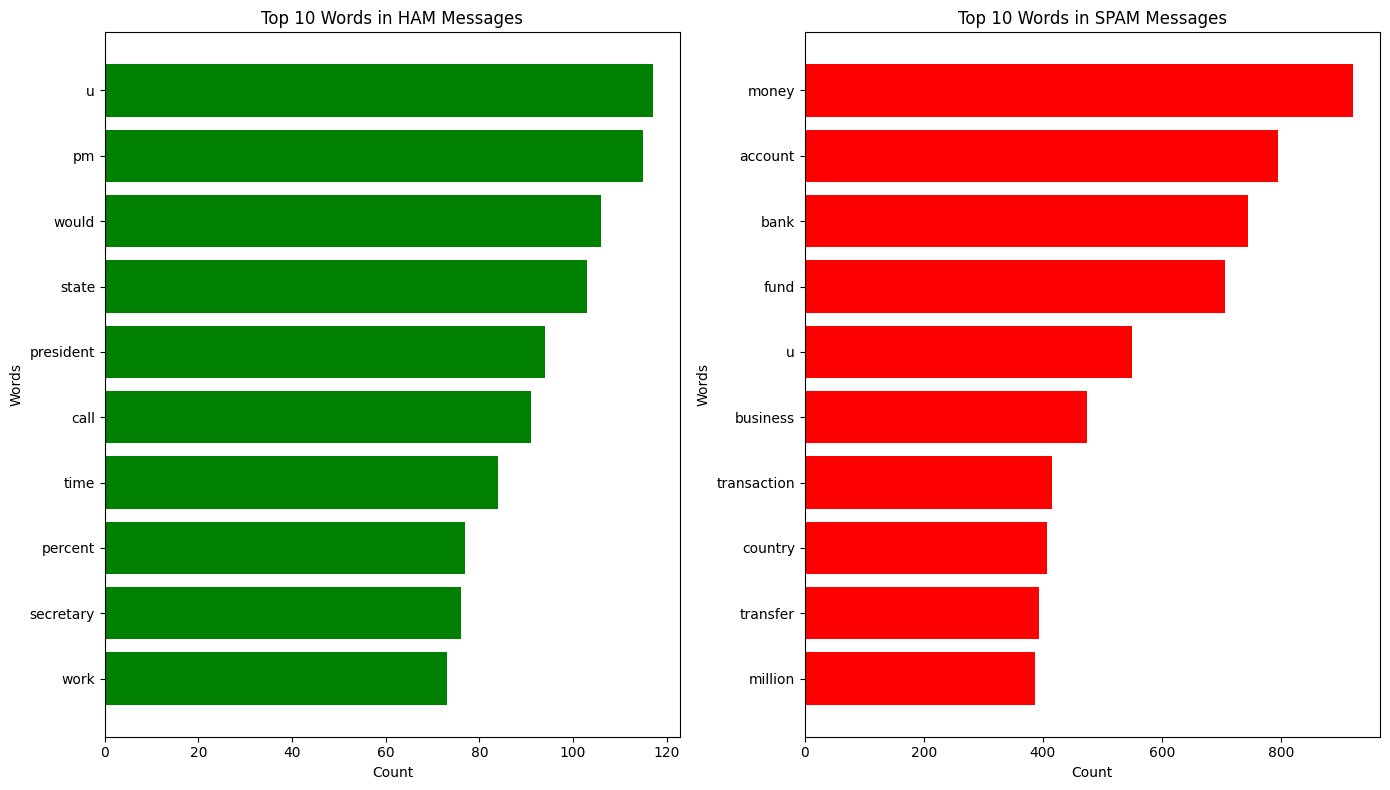

In [16]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# First, check what labels are in the dataset
print("Label distribution:", data['label'].value_counts())

# Function to get top words from a list of texts
def get_top_words(texts, n=10):
    # Combine all texts into one big string
    all_words = ' '.join(texts).split()
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Get the most common words
    top_words = word_counts.most_common(n)
    
    return top_words

# Get top words for ham messages
ham_messages = data[data['label'] == 0]['lemmatized_text']  # Assuming 0 is ham
if len(ham_messages) == 0:  # Try alternative label if needed
    ham_messages = data[data['label'] == 'ham']['lemmatized_text']

# Get top words for spam messages
spam_messages = data[data['label'] == 1]['lemmatized_text']  # Assuming 1 is spam
if len(spam_messages) == 0:  # Try alternative label if needed
    spam_messages = data[data['label'] == 'spam']['lemmatized_text']

print(f"Number of ham messages: {len(ham_messages)}")
print(f"Number of spam messages: {len(spam_messages)}")

# Only proceed if we have data
if len(ham_messages) > 0 and len(spam_messages) > 0:
    # Get top words
    ham_top_words = get_top_words(ham_messages)
    spam_top_words = get_top_words(spam_messages)
    
    # Display results
    print("\nTop 10 words in HAM messages:")
    for word, count in ham_top_words:
        print(f"{word}: {count}")
    
    print("\nTop 10 words in SPAM messages:")
    for word, count in spam_top_words:
        print(f"{word}: {count}")
    
    # Create dataframes for visualization
    ham_df = pd.DataFrame(ham_top_words, columns=['Word', 'Count'])
    spam_df = pd.DataFrame(spam_top_words, columns=['Word', 'Count'])
    
    # Plotting
    plt.figure(figsize=(14, 8))
    
    # Ham plot
    plt.subplot(1, 2, 1)
    plt.barh(ham_df['Word'].astype(str), ham_df['Count'], color='green')
    plt.title('Top 10 Words in HAM Messages')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.gca().invert_yaxis()  # To have the highest count at the top
    
    # Spam plot
    plt.subplot(1, 2, 2)
    plt.barh(spam_df['Word'].astype(str), spam_df['Count'], color='red')
    plt.title('Top 10 Words in SPAM Messages')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.gca().invert_yaxis()  # To have the highest count at the top
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to analyze ham and spam separately.")

## Extra features

In [21]:
# First, split your data into training and validation sets
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

# Make sure the preprocessed_text column exists
# If your cleaned/lemmatized text is in a different column, replace 'lemmatized_text' with that column name
data_train['preprocessed_text'] = data_train['lemmatized_text']
data_val['preprocessed_text'] = data_val['lemmatized_text']

# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€","$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

,text,label,cleaned_text,lemmatized_text,preprocessed_text,money_mark,suspicious_words,text_len
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,regards mr nelson smithkindly reply private em...,regard mr nelson smithkindly reply private ema...,regard mr nelson smithkindly reply private ema...,1,0,75
535,I have not been able to reach oscar this am. W...,0,able reach oscar supposed send pdb receive,able reach oscar supposed send pdb receive,able reach oscar supposed send pdb receive,1,0,42
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,huma abedin bim checking pat work jack jake re...,huma abedin bim checking pat work jack jake re...,huma abedin bim checking pat work jack jake re...,1,0,79
557,I can have it announced here on Monday - can't...,0,announced monday cant today,announced monday cant today,announced monday cant today,1,0,27
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,bank africaagence san pedro bp san pedro cote ...,bank africaagence san pedro bp san pedro cote ...,bank africaagence san pedro bp san pedro cote ...,1,1,1117


## How would work the Bag of Words with Count Vectorizer concept?

Shape of Bag of Words matrix: (1000, 1000)
Number of unique words in vocabulary: 1000

Sample of the Bag of Words representation:
   abacha  abandoned  abidjan  able  abroad  ac  accept  acceptance  access  \
0       0          1        0     0       0   0       0           0       0   
1       0          0        0     0       0   0       0           0       0   
2       0          0        0     0       0   0       0           0       0   
3       0          0        0     0       0   0       1           1       0   
4       0          0        0     0       0   0       0           0       0   

   accord  
0       0  
1       0  
2       0  
3       0  
4       0  


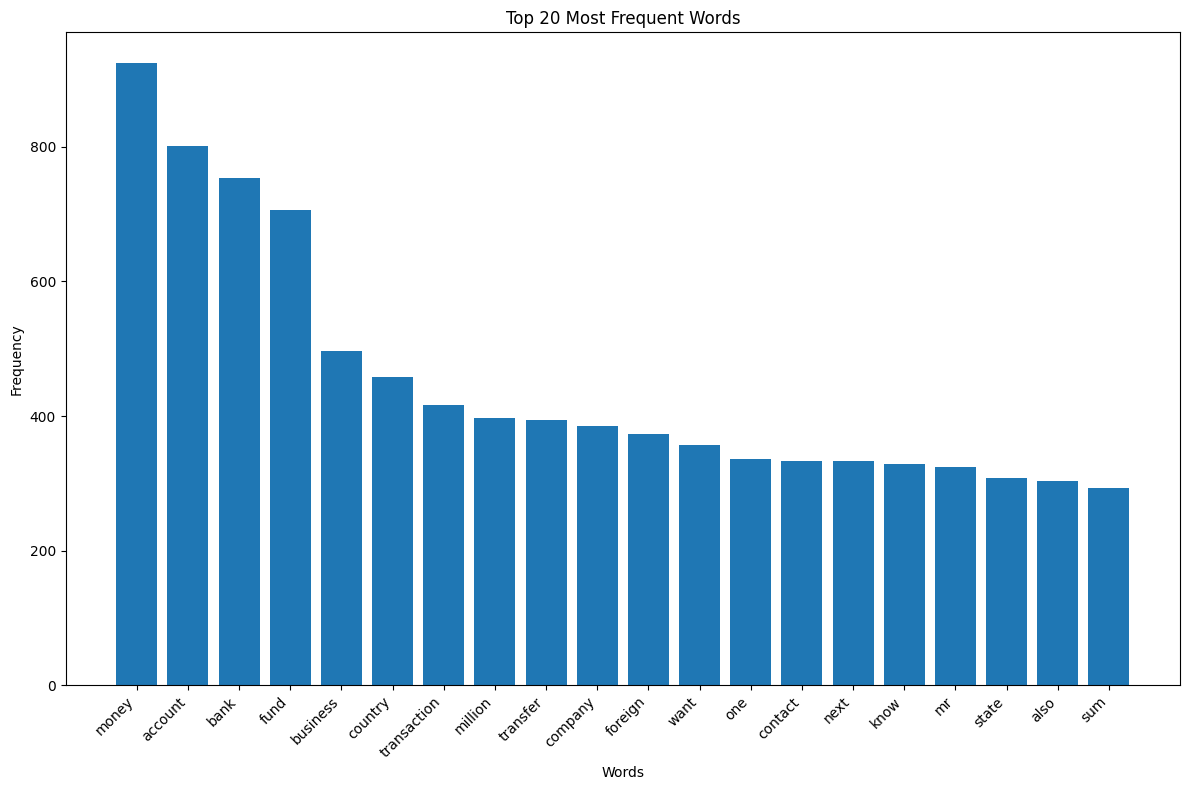

In [22]:
# Your code
## How would work the Bag of Words with Count Vectorizer concept?

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000)  # Limit to top 1000 features

# Fit and transform the preprocessed text data
# Assuming 'lemmatized_text' or 'preprocessed_text' contains your cleaned text
X_counts = count_vectorizer.fit_transform(data['lemmatized_text'])

# Get feature names (words)
feature_names = count_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing
bow_df = pd.DataFrame(X_counts.toarray(), columns=feature_names)

# Display the shape of the resulting matrix
print(f"Shape of Bag of Words matrix: {X_counts.shape}")
print(f"Number of unique words in vocabulary: {len(feature_names)}")

# Display a sample of the BoW representation
print("\nSample of the Bag of Words representation:")
print(bow_df.iloc[:5, :10])  # First 5 documents, first 10 features

# Visualize word frequencies across the corpus
word_freq = np.sum(X_counts.toarray(), axis=0)
top_indices = word_freq.argsort()[-20:][::-1]  # Top 20 words

plt.figure(figsize=(12, 8))
plt.bar(range(20), word_freq[top_indices])
plt.xticks(range(20), [feature_names[i] for i in top_indices], rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [ ]:
# Your code

## And the Train a Classifier?

In [ ]:
# Your code

### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).

In [ ]:
# Your code